# Basic lesion analysis

In [1]:
%pylab inline
import numpy as np
import pandas as pd
import cPickle as pickle
import seaborn as sns
sns.set_style('whitegrid')

Populating the interactive namespace from numpy and matplotlib


First we download and read both the lesion dataframe and the transistor data

In [12]:
!wget -O lesions_df.csv https://s3-us-west-2.amazonaws.com/ericmjonas-public/data/neuroproc/lesions_df.csv
!wget -O transistors.csv -N https://s3-us-west-2.amazonaws.com/ericmjonas-public/data/neuroproc/transistors.csv

--2017-01-02 13:16:09--  https://s3-us-west-2.amazonaws.com/ericmjonas-public/data/neuroproc/lesions_df.csv
Resolving s3-us-west-2.amazonaws.com (s3-us-west-2.amazonaws.com)... 52.218.144.8
Connecting to s3-us-west-2.amazonaws.com (s3-us-west-2.amazonaws.com)|52.218.144.8|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 377732 (369K) [text/csv]
Saving to: ‘lesions_df.csv’

100%[======================================>] 377,732     1.62MB/s   in 0.2s   

2017-01-02 13:16:09 (1.62 MB/s) - ‘lesions_df.csv’ saved [377732/377732]

for details.

--2017-01-02 13:16:09--  https://s3-us-west-2.amazonaws.com/ericmjonas-public/data/neuroproc/transistors.csv
Resolving s3-us-west-2.amazonaws.com (s3-us-west-2.amazonaws.com)... 52.218.144.8
Connecting to s3-us-west-2.amazonaws.com (s3-us-west-2.amazonaws.com)|52.218.144.8|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 245130 (239K) [text/csv]
Saving to: ‘transistors.csv’

100%[======================

In [16]:
lesions_df = pd.read_csv("lesions_df.csv")
del lesions_df['transistor.1']
transistors_df = pd.read_csv("transistors.csv")

The lesion data has, for each transistor and each behavior experiment, how many frames were generated after a large number of clock ticks. If zero were generated, "lethal" is True. 

In [18]:
lesions_df.head()

,transistor,expname,framegen,lethal
0,0,donkeykong-all_vcc,0,True
1,1,donkeykong-all_vcc,2,False
2,2,donkeykong-all_vcc,0,True
3,3,donkeykong-all_vcc,2,False
4,4,donkeykong-all_vcc,2,False


In [19]:
# reshape the dataframe
lethal_by_behavior_df =  lesions_df.pivot(index='transistor', columns='expname', values='lethal')
lethal_by_behavior_df['lethalcount'] = lethal_by_behavior_df.sum(axis=1)
lethal_by_behavior_df.head()

expname,donkeykong-all_vcc,pitfall-all_vcc,spaceinvaders-all_vcc,lethalcount
transistor,,,,
0,True,True,True,3
1,False,False,False,0
2,True,True,True,3
3,False,False,False,0
4,False,False,False,0


In [20]:
# identifiy the transistors which were only lethal in a single behavioral state
only_lethal_in = lethal_by_behavior_df[lethal_by_behavior_df.lethalcount == 1].copy()
only_lethal_in.head()
def foo(x):
    for c in x.keys():
        if 'vcc' in c and x[c]:
            return c
only_lethal_in['whichexp'] = only_lethal_in.apply(foo, axis=1)
only_lethal_in.head()

expname,donkeykong-all_vcc,pitfall-all_vcc,spaceinvaders-all_vcc,lethalcount,whichexp
transistor,,,,,
16,True,False,False,1,donkeykong-all_vcc
17,False,False,True,1,spaceinvaders-all_vcc
35,False,False,True,1,spaceinvaders-all_vcc
75,False,False,True,1,spaceinvaders-all_vcc
77,True,False,False,1,donkeykong-all_vcc


In [7]:
only_lethal_in.whichexp.value_counts()

donkeykong-all_vcc       98
spaceinvaders-all_vcc    49
pitfall-all_vcc          39
Name: whichexp, dtype: int64

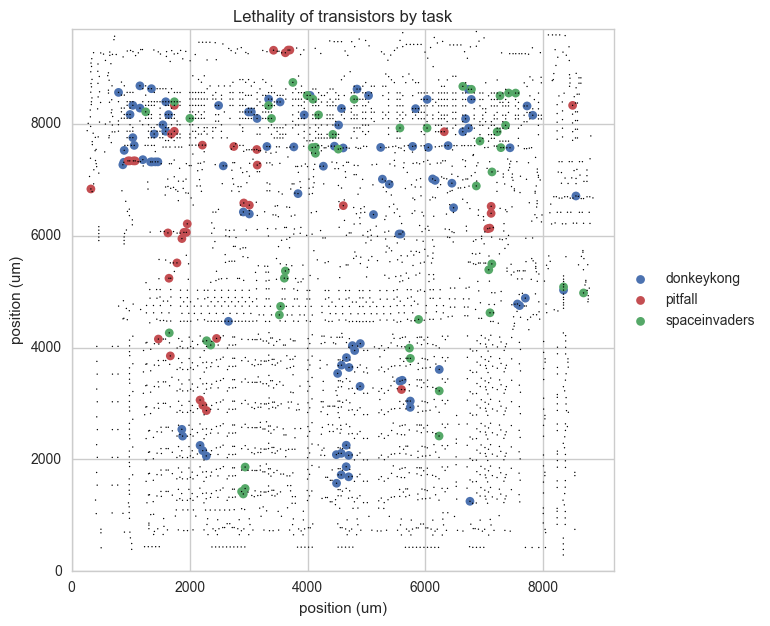

In [11]:
pylab.figure(figsize=(7, 7))

current_palette = sns.color_palette()
tasks = ['donkeykong', 'spaceinvaders', 'pitfall']

for exp_i, (exp_name, lethal) in enumerate(only_lethal_in.groupby('whichexp')):
    trans_sub = transistors_df.ix[lethal.index]
    short_name = exp_name.split('-')[0]
    c = current_palette[tasks.index(short_name)]
    pylab.scatter(trans_sub.x, trans_sub.y, 
                  c=c,
                  alpha=1.0, s=40.0, edgecolor='none', label=short_name)

pylab.scatter(transistors_df.x, transistors_df.y, c='k', alpha=1.0, s=1.0, edgecolor='none', label=None)

pylab.xlim(0, 9200)
pylab.ylim(0, 9700)
pylab.xlabel("position (um)")
pylab.ylabel("position (um)")
pylab.title("Lethality of transistors by task")
lgd = pylab.legend(loc='center left', bbox_to_anchor=(1, 0.5))

